# Tutorial for Bayesian Optimization, Active Learning and Self-Driving Labs - Notebook 2

>**Note**: This notebook is shared as 'view-only' to ensure proper version control. While you are able to make changes to the code as you wish, these changes will not be saved to the primary version. We highly recommend that you make your own copy which will allow you to save any changes made on your own version. To accomplish this, go to File -> Save a Copy in Drive in the toolbar at the top of the page.  
We encourage readers to copy, modify, and use this code for their own projects. We ask that any publications which utilize this tutorial as a starting point to cite the accompanying article. This helps others also find this tutorial and use it as a resource for their own projects.


## Overview

The goal of this tutorial is to walk through the essentials of **Active Learning (AL)** from start to finish, providing both conceptual explanations and hands-on code examples. A basic understanding of **Machine Learning (ML)** is assumed. If you're new to ML, we highly recommend reviewing:

- **A User's Guide to Machine Learning**: https://doi.org/10.1021/acspolymersau.2c00037  
- **Accompanying ML Colab notebook**: https://www.gormleylab.com/MLcolab

### Tutorial Overview

This guide is structured into three main notebooks, each building on the last:

---

#### Tutorial Notebook 1: Bayesian Optimization in 1D  
We begin with a simple, one-dimensional example of **Bayesian Optimization (BO)** applied to a black-box function. This notebook introduces the foundational concepts of active learning, including:  
- Fitting a Gaussian Process (GP) to observed data  
- Using acquisition functions to choose new sampling points  

---

> #### Tutorial Notebook 2: Deeper dive into Active Learning  
> Next, we extend the BO framework to higher-dimensional spaces. This notebook explores:  
> - Acquisition functions in complex domains  
> - The trade-off between exploitation (sampling where predictions are high) and exploration (sampling where uncertainty is high)  
> - Alternative ML models and their effects on BO
> - Alternative BO algorithms and their effects on optimization efficiency

---

#### Tutorial Notebook 3: Application to Real-World Data - Self-Driving Labs

Finally, we apply active learning to a **real experimental dataset** involving enzymes. This notebook demonstrates how active learning can be used to efficiently select informative experiments and accelerate discovery in scientific research. This notebook explores:

- Seed Library Generation (Initial sampling)
- Structure of Self-Driving Labs
- Closing the Loop

## Tutorial Notebook 2: To Infinity and Beyond!
Previously, you observed how to maximize a 1D function using Gaussian Process (GP) - based Bayesian optimization with the expected improvement acquisition function. However, Bayesian optimization is often used to optimize multi-dimensional functions, and it can make use of different ML models and acquisition functions. Also, in SDL settings, batch selection is often employed. In this notebook, we will optimize a 2D black-box function. Additionally, we will review different choices for ML model, acquisition function, and batch selection. For each part of the BO algorithm, we'll see how different choices impact optimization efficiency.

<b>This notebook can be broken into the following outline:</b>
- 2.1 - Introduce a 2D black-box function solve.
- 2.2 - Show GP/EI-based BO on the 2D black-box function.
- 2.3 - Review alternative ML models and their impact on BO.
- 2.4 - Review alternative acquisition functions and their impact on BO.
- 2.5 - Introduce batch selection.

#### Importing Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel,DotProduct
from scipy.stats import norm
import warnings

# Supress code warnings for clarity, uncomment when making changes/running into problems
warnings.filterwarnings("ignore")

#### 2.1 - Introduce a 2D black-box function to solve.

To demonstrate BO in higher dimensions, we'll use the Müller-Brown potential. The Müller-Brown potential is a two-dimensional potential energy surface used as a toy model in physics and chemistry to model reaction pathways and transition states. It's a good test function for BO because there are many local minima, but one global minimum. That way, we'll see how robust different formulations of BO are to the presence of local minima. Here, we'll see if we can quickly identify the minimum in the Müller-Brown potential using BO. We construct and visualize the Müller-Brown potential below.

In [3]:
def construct_muller_brown(n_points=100):
    '''
        Constructs a Müller-Brown potential dataset with the specified number of points
        along each dimension.
    '''
    A = (-200, -100, -170, 15)
    a = (-1, -1, -6.7, 0.7)
    b = (0, 0, 11, 0.6)
    c = (-10, -10, -6.5, 0.7)
    x0 = (1, 0, -0.5, -1)
    y0 = (0, 0.5, 1.5, 1)

    x = np.linspace(-1.5, 1.2, n_points)
    y = np.linspace(-0.5, 2.0, n_points)
    X, Y = np.meshgrid(x, y)
    V = np.zeros(X.shape)
    for idx in range(4):
        t1 = a[idx] * (X - x0[idx]) ** 2
        t2 = b[idx] * (X - x0[idx]) * (Y - y0[idx])
        t3 = c[idx] * (Y - y0[idx]) ** 2
        V += A[idx] * np.exp(t1 + t2 + t3)

    V = V.reshape(-1)
    X = X.reshape(-1)
    Y = Y.reshape(-1)
    keep_idx = np.argwhere(V < 180).reshape(-1)
    X = X[keep_idx]
    Y = Y[keep_idx]
    V = V[keep_idx]
    V = V / np.max(V)

    return np.hstack((X.reshape(-1,1), Y.reshape(-1,1))), V.reshape(-1)

Global Minimum is -0.814 at (X₁, X₂) = (-0.55,1.44)


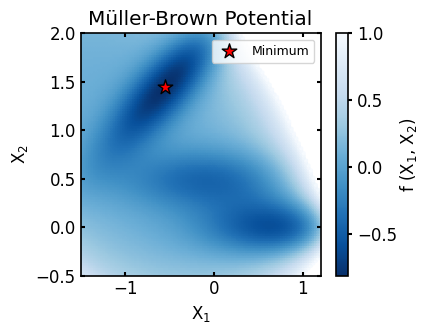

In [4]:
# Get Müller-Brown (MB) potential.
domain, labels = construct_muller_brown()
vmin = np.min(labels)
vmax = np.max(labels)

# Find and plot global minimum location
min_idx = np.argmin(labels)
min_point = domain[min_idx]

# Print value of minimum to optimize for
print(f'Global Minimum is {np.round(vmin, 3)} at (X₁, X₂) = ({np.round(min_point[0], 2)},{np.round(min_point[1], 2)})')

# Visualize Müller-Brown potential.
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(1,1,figsize=(4.5,3.5))
c = ax.scatter(domain[:,0], domain[:,1], s=4, c=labels, cmap='Blues_r', vmin=vmin, vmax=vmax)

# Plot the global minimum point
ax.scatter(min_point[0], min_point[1], marker='*', color='red', edgecolor='black', s=120, zorder=3, label='Minimum')
ax.legend(loc='upper right', fontsize=9)
ax.set_xlabel(r'X$_1$')
ax.set_ylabel(r'X$_2$')
ax.set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
ax.set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
ax.set_title('Müller-Brown Potential')
ax.tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
cbar = plt.colorbar(c)
cbar.set_label(r'f (X$_1$, X$_2$)', labelpad=1)
cbar.ax.tick_params(width=1.5, length=3.0)
plt.tight_layout()
plt.show()

#### 2.2 - Show GP/EI-based BO on the 2D Black-Box function.

We'll start by showing how the BO method used above, which is based on Gaussian Process Regression (GPR) and the Expected Improvement (EI) acquisition function, can be readily applied to a 2D dataset. This will help us get used to the 2D visualizations and their meaning using an algorithm we already understand.

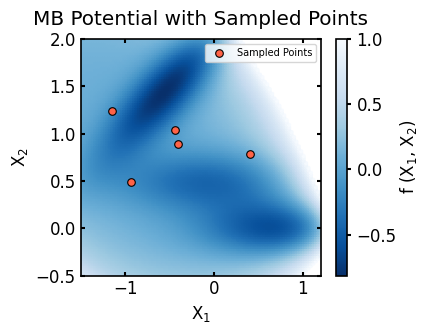

In [5]:
# Seed active learning using a set of randomly chosen points.
np.random.seed(1)
idx = [i for i in range(domain.shape[0])]
chosen_idx = np.random.choice(idx, size=5, replace=False).tolist()

# Visualize choice of seed data.
fig, ax = plt.subplots(1,1,figsize=(4.5,3.5))
c = ax.scatter(domain[:,0], domain[:,1], s=4, c=labels, cmap='Blues_r', vmin=vmin, vmax=vmax)
ax.scatter(domain[chosen_idx,0], domain[chosen_idx,1], s=30, color='tomato', edgecolor='black', linewidth=0.8,label='Sampled Points')
ax.set_xlabel(r'X$_1$')
ax.set_ylabel(r'X$_2$')
ax.set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
ax.set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
ax.tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
cbar = plt.colorbar(c)
cbar.set_label(r'f (X$_1$, X$_2$)', labelpad=1)
cbar.ax.tick_params(width=1.5, length=3.0)
plt.legend(loc='upper right', frameon=True, fontsize=7)
plt.title('MB Potential with Sampled Points',pad=10)
plt.tight_layout()
plt.show()

After choosing an initial set of data, we'll train a GPR. Below, we plot the predictions of the GPR on the entire domain. We also plot the uncertainties of the GPR, quantified by the standard deviation in its prediction, on the entire domain. We see that GPR uncertainties increase far from the points that have already been chosen.

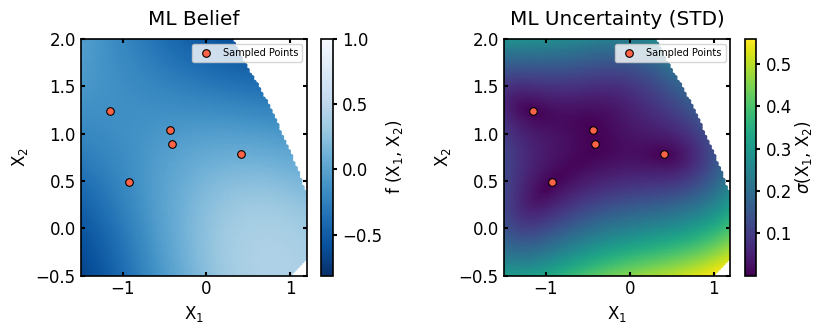

In [6]:
# Record progress.
current_minimum = [np.min(labels[chosen_idx])]

# Train a Gaussian process regression model on these points.
kernel = RBF(length_scale_bounds=(0.005, 10.0))
gp_model = GaussianProcessRegressor(kernel=kernel)
gp_model.fit(domain[chosen_idx], labels[chosen_idx])
y_pred, y_std = gp_model.predict(domain, return_std=True)

# Visualize GP model predictions on design space.
fig, axs = plt.subplots(1,2,figsize=(8.4,3.5))
c = axs[0].scatter(domain[:,0], domain[:,1], s=4, c=y_pred, cmap='Blues_r', vmin=vmin, vmax=vmax)
axs[0].scatter(domain[chosen_idx,0], domain[chosen_idx,1], s=30, color='tomato', edgecolor='black', linewidth=0.8,label='Sampled Points')
axs[0].set_xlabel(r'X$_1$')
axs[0].set_ylabel(r'X$_2$')
axs[0].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
axs[0].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
axs[0].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
axs[0].set_title('ML Belief',pad=10)
axs[0].legend(loc='upper right', frameon=True, fontsize=7)
cbar = plt.colorbar(c)
cbar.set_label(r'f (X$_1$, X$_2$)', labelpad=1)
cbar.ax.tick_params(width=1.5, length=3.0)
plt.legend()

# Visualize GP uncertainties on design space.
c = axs[1].scatter(domain[:,0], domain[:,1], s=4, c=y_std, cmap='viridis')
axs[1].scatter(domain[chosen_idx,0], domain[chosen_idx,1], s=30, color='tomato', edgecolor='black', linewidth=0.8,label='Sampled Points')
axs[1].set_xlabel(r'X$_1$')
axs[1].set_ylabel(r'X$_2$')
axs[1].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
axs[1].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
axs[1].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
axs[1].set_title('ML Uncertainty (STD)',pad=10)
axs[1].legend(loc='upper right', frameon=True, fontsize=7)
cbar = plt.colorbar(c)
cbar.set_label(r'$\sigma$(X$_1$, X$_2$)', labelpad=1)
cbar.ax.tick_params(width=1.5, length=3.0)

plt.tight_layout()
plt.show()

After training the GPR, we can compute the expected improvement acquisition function across the design space and see where the model prioritizes choosing new points.

In [7]:
def expected_improvement(y_pred, y_std, y_min, eta=0.0):
    '''
        Computes the EI acquisition function for all provided labels.
        This implementation is specific to minimization, although a few
        sign changes should make it suitable for maximization.
    '''

    z = (y_min - y_pred - eta) / y_std
    ei = (y_min - y_pred - eta) * norm.cdf(z) + y_std * norm.pdf(z)

    return ei

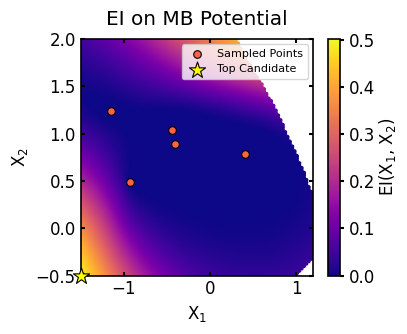

In [8]:
# Assign variables so it is standalone
current_minimum_i1 = current_minimum.copy()
chosen_idx_i1 = chosen_idx.copy()

# Add point which maximizes the acquisition function to the training set.
acq = expected_improvement(y_pred, y_std, y_min=np.min(labels[chosen_idx_i1]))
new_idx = np.argmax(acq).item()
chosen_idx_i1.append(new_idx)
current_minimum_i1.append(np.min(labels[chosen_idx_i1]))


# Show acquisition function and newly chosen point.
fig, ax = plt.subplots(1,1,figsize=(4.2,3.5))
c = ax.scatter(domain[:,0], domain[:,1], s=4, c=acq, cmap='plasma')
ax.scatter(domain[chosen_idx_i1,0], domain[chosen_idx_i1,1], s=30, color='tomato', edgecolor='black', linewidth=0.8,label='Sampled Points')
ax.scatter(domain[chosen_idx_i1[-1],0], domain[chosen_idx_i1[-1],1], s=150, marker='*', color='yellow', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10,label='Top Candidate')
ax.set_xlabel(r'X$_1$')
ax.set_ylabel(r'X$_2$')
ax.set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
ax.set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
ax.tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
cbar = plt.colorbar(c)
cbar.set_label(r'EI(X$_1$, X$_2$)', labelpad=1)
cbar.ax.tick_params(width=1.5, length=3.0)
plt.legend(loc='upper right',frameon=True,fontsize=8)
plt.title('EI on MB Potential', pad=10)
plt.tight_layout()
plt.show()

Above, we see that we choose a point that is far from those already chosen and predicted to have reasonably negative values. So, it looks like things are working as we expect! Now, as we did in Section 1, we can repeat this process several times and evaluate how well our model is doing. Below, we visualize the progress for a few more iterations.

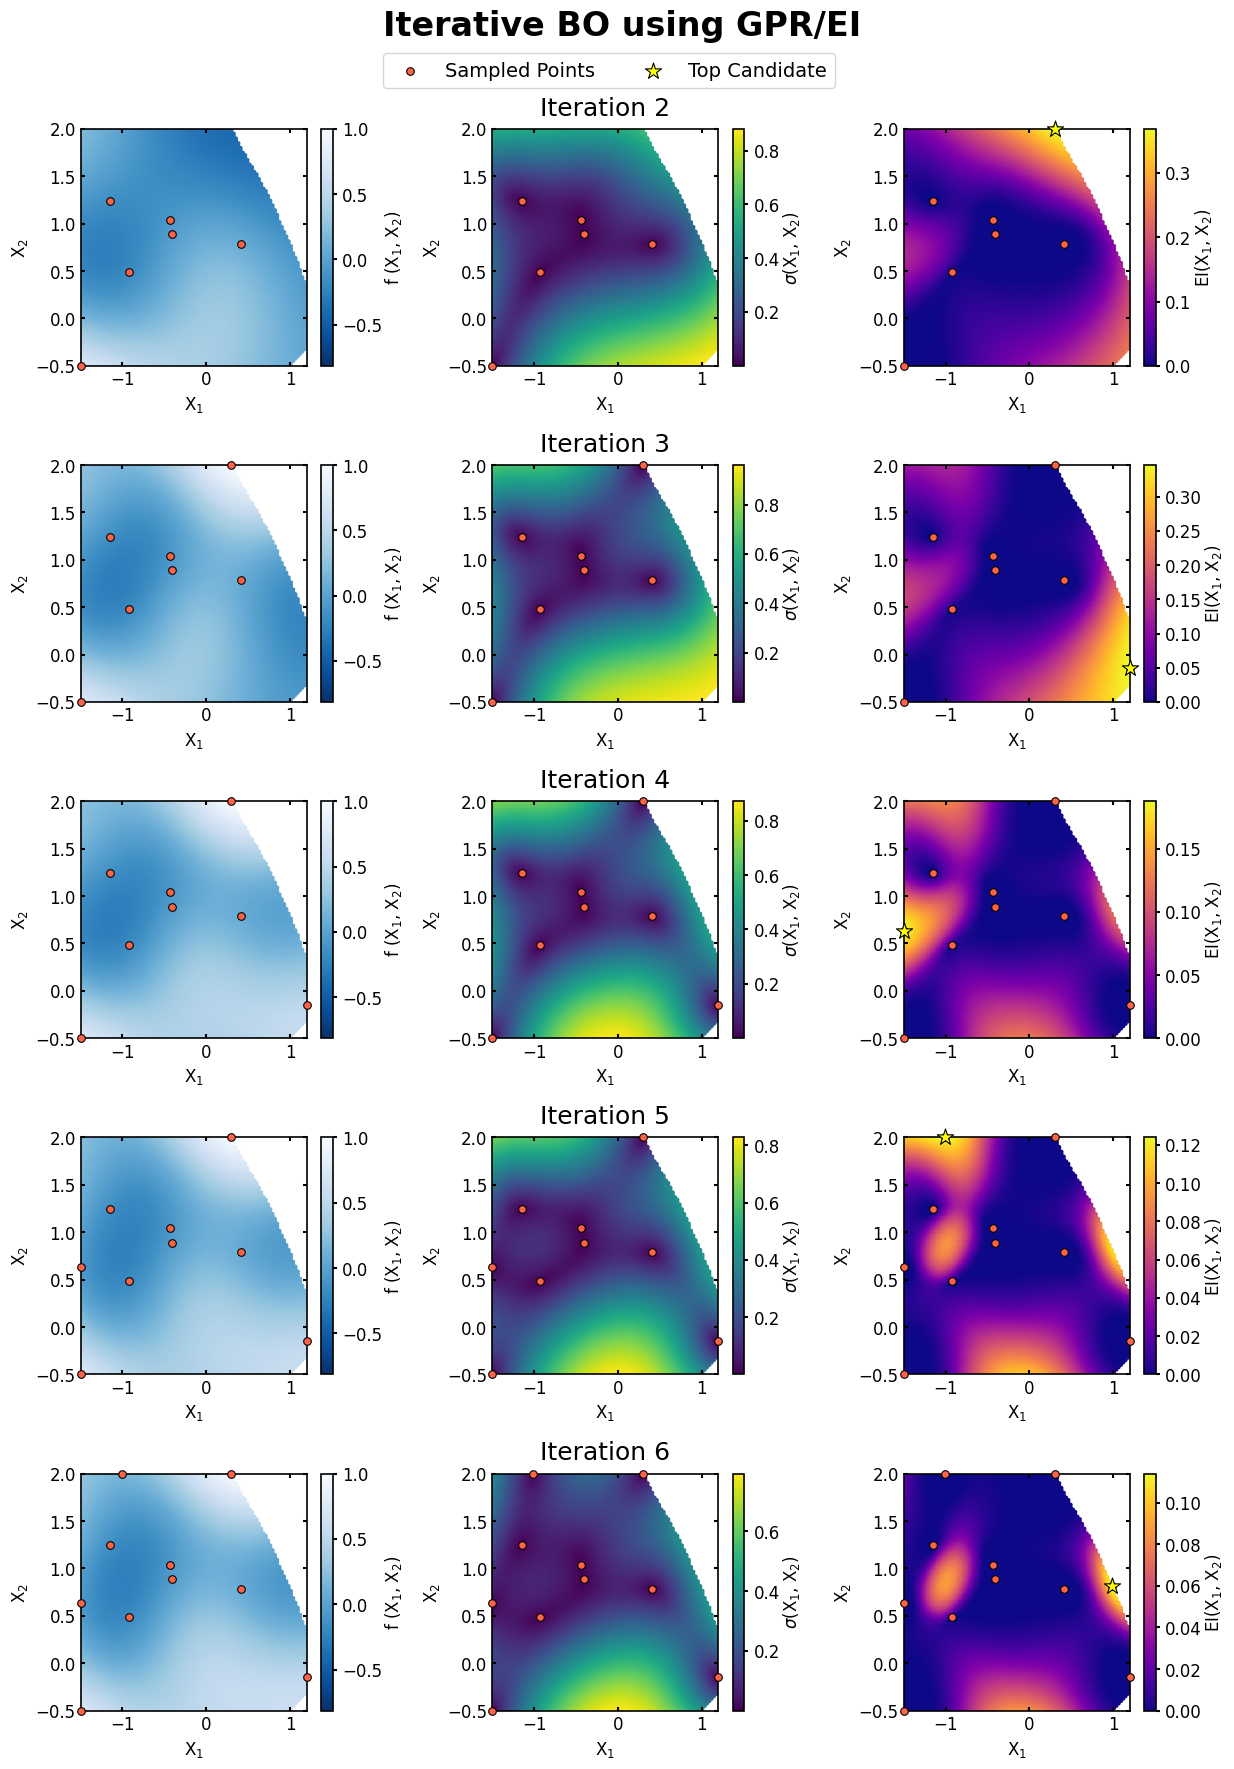

In [10]:
# Assign variables so it is standalone
chosen_idx_loop = chosen_idx_i1.copy()
current_minimum_loop = current_minimum_i1.copy()

fig, axs = plt.subplots(5,3,figsize=(4.2 * 3,3.5 * 5))
for iteration in range(5):

    # Fit the GP model to new training data.
    gp_model = GaussianProcessRegressor(kernel=kernel)
    gp_model.fit(domain[chosen_idx_loop], labels[chosen_idx_loop])
    y_pred, y_std = gp_model.predict(domain, return_std=True)

    # Visualize GP predictions on design space.
    c = axs[iteration,0].scatter(domain[:,0], domain[:,1], s=4, c=y_pred, cmap='Blues_r', vmin=vmin, vmax=vmax)
    axs[iteration,0].scatter(domain[chosen_idx_loop,0], domain[chosen_idx_loop,1], s=30, color='tomato', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10,label='Sampled Points')
    axs[iteration,0].set_xlabel(r'X$_1$')
    axs[iteration,0].set_ylabel(r'X$_2$')
    axs[iteration,0].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
    axs[iteration,0].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
    axs[iteration,0].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
    cbar = plt.colorbar(c)
    cbar.set_label(r'f (X$_1$, X$_2$)', labelpad=1)
    cbar.ax.tick_params(width=1.5, length=3.0)

    # Visualize GP uncertainties on design space.
    c = axs[iteration,1].scatter(domain[:,0], domain[:,1], s=4, c=y_std, cmap='viridis')
    axs[iteration,1].scatter(domain[chosen_idx_loop,0], domain[chosen_idx_loop,1], s=30, color='tomato', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10,label='Sampled Points')
    axs[iteration,1].set_xlabel(r'X$_1$')
    axs[iteration,1].set_ylabel(r'X$_2$')
    axs[iteration,1].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
    axs[iteration,1].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
    axs[iteration,1].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
    cbar = plt.colorbar(c)
    cbar.set_label(r'$\sigma$(X$_1$, X$_2$)', labelpad=1)
    cbar.ax.tick_params(width=1.5, length=3.0)
    axs[iteration,1].set_title(f'Iteration {iteration+2}',fontsize=18,pad=10)

    # Evaluate the acquisition function.
    acq_loop = expected_improvement(y_pred, y_std, y_min=np.min(labels[chosen_idx_loop]))

    # Choose a new point and record progress.
    new_idx = np.argmax(acq_loop).item()
    chosen_idx_loop.append(new_idx)
    current_minimum_loop.append(np.min(labels[chosen_idx_loop]))

    # Visualize acquisition function on design space.
    c = axs[iteration,2].scatter(domain[:,0], domain[:,1], s=4, c=acq_loop, cmap='plasma')
    axs[iteration,2].scatter(domain[chosen_idx_loop,0], domain[chosen_idx_loop,1], s=30, color='tomato', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10,label='Sampled Points')
    axs[iteration,2].scatter(domain[chosen_idx_loop[-1],0], domain[chosen_idx_loop[-1],1], s=150, marker='*', color='yellow', edgecolor='black', linewidth=0.8, clip_on=False, zorder=11,label='Top Candidate')
    axs[iteration,2].set_xlabel(r'X$_1$')
    axs[iteration,2].set_ylabel(r'X$_2$')
    axs[iteration,2].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
    axs[iteration,2].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
    axs[iteration,2].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
    cbar = plt.colorbar(c)
    cbar.set_label(r'EI(X$_1$, X$_2$)', labelpad=1)
    cbar.ax.tick_params(width=1.5, length=3.0)
handle, label = axs[1,2].get_legend_handles_labels()
fig.legend(handle,label,loc=(0.31,0.95),ncol=2,frameon=True,fontsize=14)
fig.suptitle('Iterative BO using GPR/EI', fontsize=24, y=1.01,fontweight='bold')
plt.tight_layout()
plt.show()

Looks like we have an automated optimization method! To investigate further, we'll keep running our algorithm for many more iterations and see how close we are to finding the global minimum.

In [11]:
# Repeat BO for 50 more iterations. Running multiple times will stack iterations
for iteration in range(50):

    # Fit the GP model to new training data.
    gp_model = GaussianProcessRegressor(kernel=kernel)
    gp_model.fit(domain[chosen_idx_loop], labels[chosen_idx_loop])
    y_pred, y_std = gp_model.predict(domain, return_std=True)

    # Evaluate the acquisition function.
    acq = expected_improvement(y_pred, y_std, y_min=np.min(labels[chosen_idx_loop]))

    # Choose a new point and record progress.
    new_idx = np.argmax(acq).item()
    chosen_idx_loop.append(new_idx)
    current_minimum_loop.append(np.min(labels[chosen_idx_loop]))

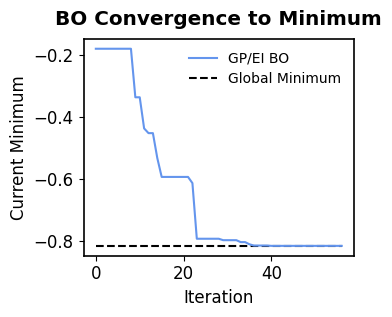

In [12]:
# Evaluate progress towards global minimum.
fig, ax = plt.subplots(1,1,figsize=(3.8,3.33))
frames = [i for i in range(len(current_minimum_loop))]
ax.plot(frames, current_minimum_loop, label='GP/EI BO', zorder=3, color='cornflowerblue')
ax.plot(frames, [np.min(labels) for _ in frames], linestyle='dashed', color='black', label='Global Minimum', zorder=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Current Minimum')
ax.legend(fancybox=False, edgecolor='white', fontsize = 10)
plt.title('BO Convergence to Minimum',pad=10,fontweight='bold')
plt.tight_layout()
plt.show()

It looks like our BO scheme was able to find the global minimum! It was able to do so after 42 iterations. In the later sections, we'll see if we can improve on this by using different models, acquisition functions, and batch selection strategies!

#### 2.3 - Review alternative ML models and their impact on BO.

Previously, we see that GP/EI-based BO is able to identify the global minimum on the Müller-Brown potential. But how would the performance of BO change if we used different ML models instead of GPs? In this section, we'll look at two alternatives to GPs for BO. We'll consider (1) Random Forests and (2) Neural Networks.

We'll start by looking at Random Forests (RFs). RFs are ensembles of decision trees. This means that many decision trees are fitted to the training data, and predictions are made by combining the predictions of each individual decision tree. For an ML model to be used in BO, we need predictions *and* uncertainties. For RFs, a clear measure of uncertainty is the spread, or standard deviation, in predictions from the individual decision trees. Below, we implement a wrapper for sklearn's RandomForestRegressor that does just this. We'll use this implementation to keep our BO code clean.

In [13]:
from sklearn.ensemble import RandomForestRegressor

class RandomForestSurrogate:
    '''
        A wrapper for the sklearn RandomForestRegressor that provides
        standard deviations in model predictions when specified.
    '''

    def __init__(self):
        self.name = 'rf'
        self.model = RandomForestRegressor(n_estimators=300)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X, return_std=False):
        '''
            Get predictions of the RF model and return standard deviation
            in decision tree predictions if specified.
        '''

        if not return_std:
            return self.model.predict(X)
        else:
            y_pred = self.model.predict(X)
            y_preds = np.array([t.predict(X) for t in self.model.estimators_])
            y_std = np.std(y_preds, axis=0)
            return y_pred, y_std

We'll also take a look at Neural Networks (NNs). NNs are the repeated application of linear operators and non-linear activations to input data. The parameters associated with these linear and non-linear operations are tuned with gradient-based methods on your training data. Unlike RFs, NNs do not have a clear measure of uncertainty, and uncertainty quantification in NNs is an active area of research. Here, we'll use ensembling to get a measure of NN uncertainty. This involves training many NNs with different initial parameters on the training data. We'll use the standard deviation in model predictions as our uncertainty metric. And, since we'll have trained all of these models, we'll use the mean of these predictions as our prediction. We implement this process in another wrapper class below based on the sklearn neural network implementation.

In [14]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

class NeuralNetworkSurrogate:
    '''
        A wrapper for the sklearn MLPRegressor that provides uncertainty
        estimation via neural network ensembling.
    '''
    def __init__(self, n_models=10):
        self.name = 'nn'
        self.models = [
            MLPRegressor(hidden_layer_sizes=(100,100), solver='lbfgs', random_state=i)
            for i in range(n_models)
        ]
        self.scaler = None

    def fit(self, X, y):

        # Define a scaler based on the training data.
        self.scaler = StandardScaler().fit(X)
        X_sc = self.scaler.transform(X)

        # Fit all models to the training data.
        for model in self.models:
            model.fit(X_sc, y)

    def predict(self, X, return_std=False):

        # Scale inputs.
        X_sc = self.scaler.transform(X)

        # Get predictions for each model.
        if not return_std:
            y_preds = np.array([model.predict(X_sc) for model in self.models])
            y_pred = np.mean(y_preds, axis=0)
            return y_pred
        else:
            y_preds = np.array([model.predict(X_sc) for model in self.models])
            y_pred = np.mean(y_preds, axis=0)
            y_std = np.std(y_preds, axis=0)
            return y_pred, y_std

Now that we've defined our new ML models, we can see how model choice impacts BO. First, we'll get an intuition for how these models work by visualizing a few rounds of BO with each of them. First, we'll consider the RF model.

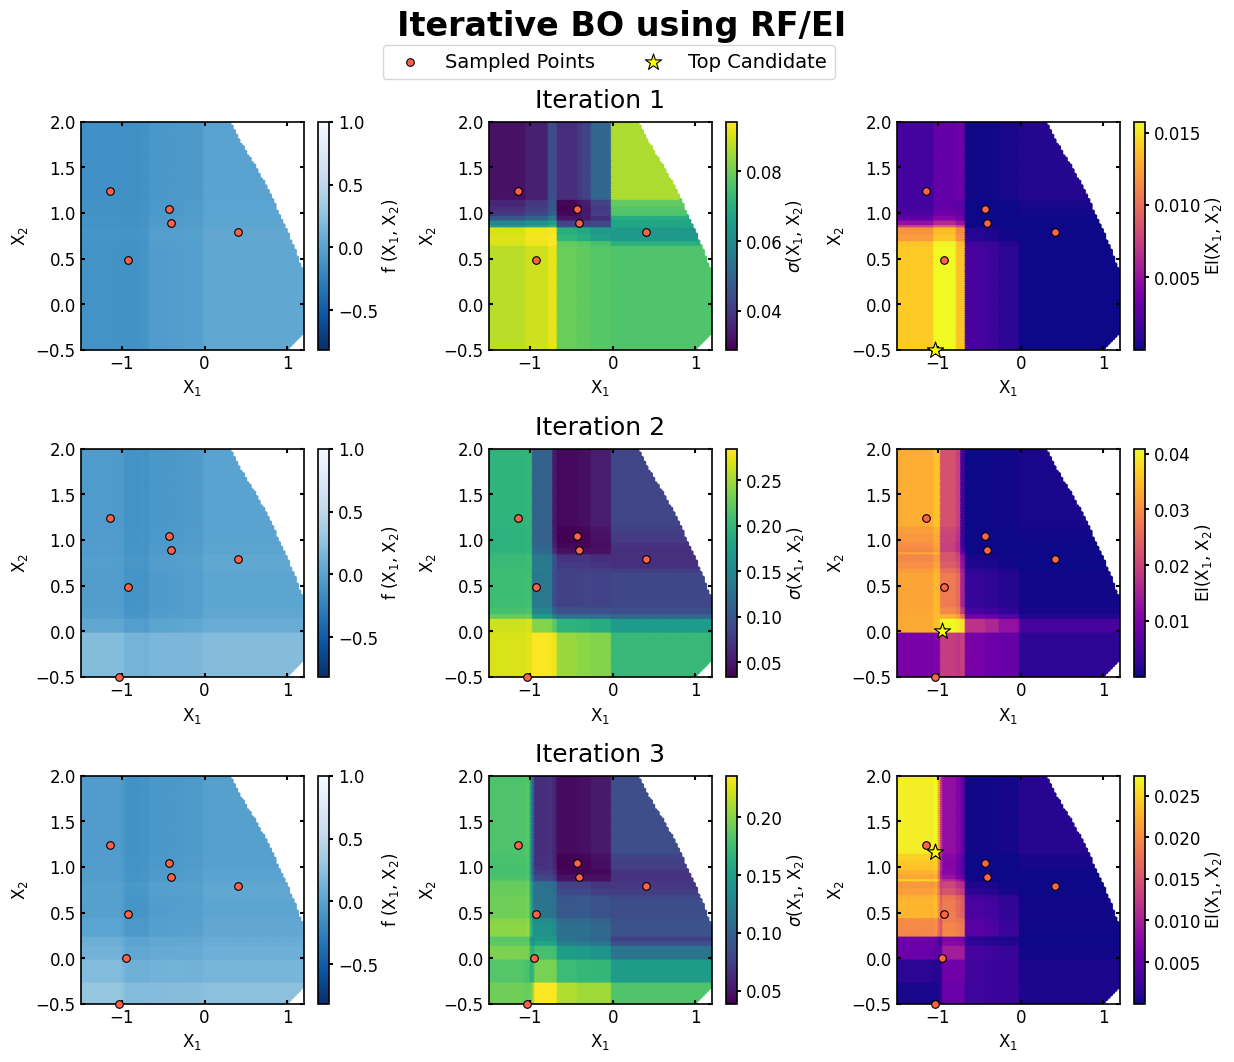

In [15]:
# Choose a new seed dataset.
np.random.seed(1)
rf_idx = [i for i in range(domain.shape[0])]
rf_chosen_idx = np.random.choice(rf_idx, size=5, replace=False).tolist()
rf_current_minimum = []

# Visualize outcomes with RF.
fig, axs = plt.subplots(3,3,figsize=(4.2 * 3,3.5 * 3))
for iteration in range(3):

    # Fit the RF model to new training data.
    model = RandomForestSurrogate()
    model.fit(domain[rf_chosen_idx], labels[rf_chosen_idx])
    y_pred, y_std = model.predict(domain, return_std=True)

    # Visualize RF predictions on design space.
    c = axs[iteration,0].scatter(domain[:,0], domain[:,1], s=4, c=y_pred, cmap='Blues_r', vmin=vmin, vmax=vmax)
    axs[iteration,0].scatter(domain[rf_chosen_idx,0], domain[rf_chosen_idx,1], s=30, color='tomato', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10)
    axs[iteration,0].set_xlabel(r'X$_1$')
    axs[iteration,0].set_ylabel(r'X$_2$')
    axs[iteration,0].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
    axs[iteration,0].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
    axs[iteration,0].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
    cbar = plt.colorbar(c)
    cbar.set_label(r'f (X$_1$, X$_2$)', labelpad=1)
    cbar.ax.tick_params(width=1.5, length=3.0)

    # Visualize RF uncertainties on design space.
    c = axs[iteration,1].scatter(domain[:,0], domain[:,1], s=4, c=y_std, cmap='viridis')
    axs[iteration,1].scatter(domain[rf_chosen_idx,0], domain[rf_chosen_idx,1], s=30, color='tomato', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10)
    axs[iteration,1].set_xlabel(r'X$_1$')
    axs[iteration,1].set_ylabel(r'X$_2$')
    axs[iteration,1].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
    axs[iteration,1].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
    axs[iteration,1].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
    cbar = plt.colorbar(c)
    cbar.set_label(r'$\sigma$(X$_1$, X$_2$)', labelpad=1)
    cbar.ax.tick_params(width=1.5, length=3.0)
    axs[iteration,1].set_title(f'Iteration {iteration+1}',fontsize=18,pad=10)

    # Evaluate the acquisition function.
    acq = expected_improvement(y_pred, y_std, np.min(labels[rf_chosen_idx]))

    # Choose a new point and record progress.
    rf_new_idx = np.argmax(acq).item()
    rf_chosen_idx.append(rf_new_idx)
    rf_current_minimum.append(np.min(labels[rf_chosen_idx]))

    # Visualize acquisition function on design space.
    c = axs[iteration,2].scatter(domain[:,0], domain[:,1], s=4, c=acq, cmap='plasma')
    axs[iteration,2].scatter(domain[rf_chosen_idx,0], domain[rf_chosen_idx,1], s=30, color='tomato', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10,label='Sampled Points')
    axs[iteration,2].scatter(domain[rf_chosen_idx[-1],0], domain[rf_chosen_idx[-1],1], s=150, marker='*', color='yellow', edgecolor='black', linewidth=0.8, clip_on=False, zorder=11,label='Top Candidate')
    axs[iteration,2].set_xlabel(r'X$_1$')
    axs[iteration,2].set_ylabel(r'X$_2$')
    axs[iteration,2].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
    axs[iteration,2].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
    axs[iteration,2].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
    cbar = plt.colorbar(c)
    cbar.set_label(r'EI(X$_1$, X$_2$)', labelpad=1)
    cbar.ax.tick_params(width=1.5, length=3.0)
handle, label = axs[1,2].get_legend_handles_labels()
fig.legend(handle,label,loc=(0.31,0.925),ncol=2,frameon=True,fontsize=14)
fig.suptitle('Iterative BO using RF/EI', fontsize=24, y=1.01,fontweight='bold')
plt.tight_layout()
plt.show()

It's clear that RFs operate *very* differently from GPs. The predictions and unceratainties of random forests tend to vary most along feature dimensions. This property can allow RFs to be very accurate on high-dimensional datasets. Next, we'll consider neural networks.

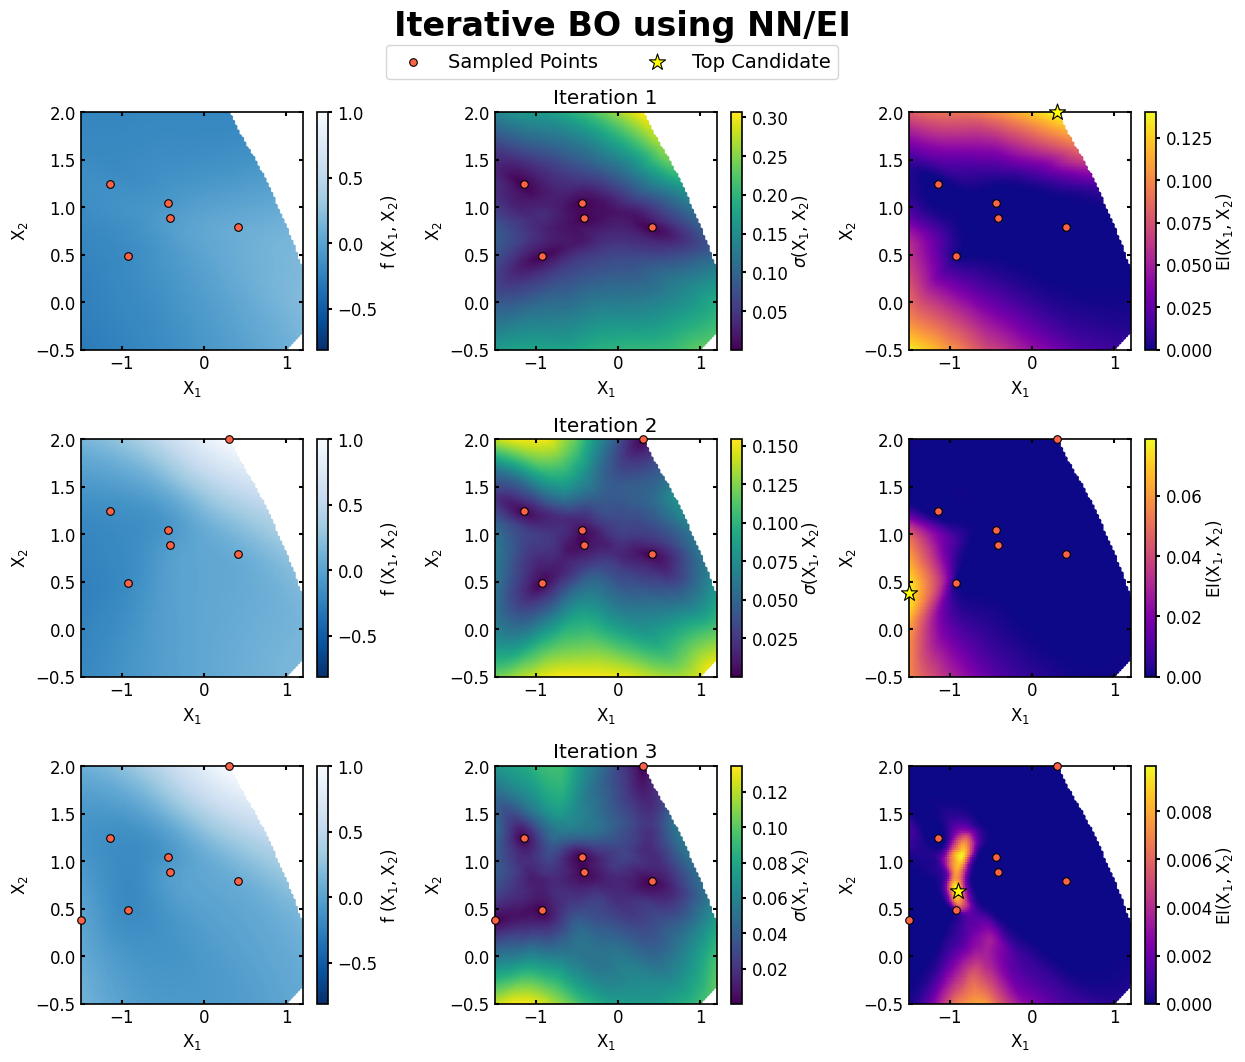

In [16]:
# Choose a new seed dataset.
np.random.seed(1)
nn_idx = [i for i in range(domain.shape[0])]
nn_chosen_idx = np.random.choice(nn_idx, size=5, replace=False).tolist()
nn_current_minimum = []

# Visualize outcomes with NNs.
fig, axs = plt.subplots(3,3,figsize=(4.2 * 3,3.5 * 3))
for iteration in range(3):

    # Fit the NN model to new training data.
    model = NeuralNetworkSurrogate()
    model.fit(domain[nn_chosen_idx], labels[nn_chosen_idx])
    y_pred, y_std = model.predict(domain, return_std=True)

    # Visualize NN predictions on design space.
    c = axs[iteration,0].scatter(domain[:,0], domain[:,1], s=4, c=y_pred, cmap='Blues_r', vmin=vmin, vmax=vmax)
    axs[iteration,0].scatter(domain[nn_chosen_idx,0], domain[nn_chosen_idx,1], s=30, color='tomato', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10)
    axs[iteration,0].set_xlabel(r'X$_1$')
    axs[iteration,0].set_ylabel(r'X$_2$')
    axs[iteration,0].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
    axs[iteration,0].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
    axs[iteration,0].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
    cbar = plt.colorbar(c)
    cbar.set_label(r'f (X$_1$, X$_2$)', labelpad=1)
    cbar.ax.tick_params(width=1.5, length=3.0)

    # Visualize NN uncertainties on design space.
    c = axs[iteration,1].scatter(domain[:,0], domain[:,1], s=4, c=y_std, cmap='viridis')
    axs[iteration,1].scatter(domain[nn_chosen_idx,0], domain[nn_chosen_idx,1], s=30, color='tomato', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10)
    axs[iteration,1].set_xlabel(r'X$_1$')
    axs[iteration,1].set_ylabel(r'X$_2$')
    axs[iteration,1].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
    axs[iteration,1].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
    axs[iteration,1].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
    cbar = plt.colorbar(c)
    cbar.set_label(r'$\sigma$(X$_1$, X$_2$)', labelpad=1)
    cbar.ax.tick_params(width=1.5, length=3.0)
    axs[iteration,1].set_title(f'Iteration {iteration+1}')

    # Evaluate the acquisition function.
    acq = expected_improvement(y_pred, y_std, np.min(labels[nn_chosen_idx]))

    # Choose a new point and record progress.
    nn_new_idx = np.argmax(acq).item()
    nn_chosen_idx.append(nn_new_idx)
    nn_current_minimum.append(np.min(labels[nn_chosen_idx]))

    # Visualize acquisition function on design space.
    c = axs[iteration,2].scatter(domain[:,0], domain[:,1], s=4, c=acq, cmap='plasma')
    axs[iteration,2].scatter(domain[nn_chosen_idx,0], domain[nn_chosen_idx,1], s=30, color='tomato', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10,label='Sampled Points')
    axs[iteration,2].scatter(domain[nn_chosen_idx[-1],0], domain[nn_chosen_idx[-1],1], s=150, marker='*', color='yellow', edgecolor='black', linewidth=0.8, clip_on=False, zorder=11,label='Top Candidate')
    axs[iteration,2].set_xlabel(r'X$_1$')
    axs[iteration,2].set_ylabel(r'X$_2$')
    axs[iteration,2].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
    axs[iteration,2].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
    axs[iteration,2].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
    cbar = plt.colorbar(c)
    cbar.set_label(r'EI(X$_1$, X$_2$)', labelpad=1)
    cbar.ax.tick_params(width=1.5, length=3.0)

handle, label = axs[1,2].get_legend_handles_labels()
fig.legend(handle,label,loc=(0.31,0.925),ncol=2,frameon=True,fontsize=14)
fig.suptitle('Iterative BO using NN/EI', fontsize=24, y=1.01,fontweight='bold')
plt.tight_layout()
plt.show()

NNs seem to make smooth predictions, unlike RFs but similar to GPs. However, the uncertainties are not as correlated with distance from current training data in the way that they are for GPs. The capacity for NNs to learn more expressive functions of the underlying data can be beneficial or detrimental on different kinds of tasks. To get a sense for which ML model is best on the Müller-Brown potential, we execute BO for GPs, RFs, and NNs for 50 iterations. We report the results below.

In [17]:
# Get performance for GP/EI-BO.
gp_minima = []
print('Performing BO with GPs...')
np.random.seed(1)
idx = [i for i in range(domain.shape[0])]
chosen_idx = np.random.choice(idx, size=5, replace=False).tolist()
for iteration in range(50):

    # Fit the GP model to new training data.
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(domain[chosen_idx], labels[chosen_idx])
    y_pred, y_std = model.predict(domain, return_std=True)

    # Evaluate the acquisition function.
    acq = expected_improvement(y_pred, y_std, y_min=np.min(labels[chosen_idx]))

    # Choose a new point and record progress.
    new_idx = np.argmax(acq).item()
    chosen_idx.append(new_idx)
    gp_minima.append(np.min(labels[chosen_idx]))

# Get performance for RF/EI-BO.
rf_minima = []
print('Performing BO with RFs...')
np.random.seed(1)
idx = [i for i in range(domain.shape[0])]
chosen_idx = np.random.choice(idx, size=5, replace=False).tolist()
for iteration in range(50):

    # Fit the GP model to new training data.
    model = RandomForestSurrogate()
    model.fit(domain[chosen_idx], labels[chosen_idx])
    y_pred, y_std = model.predict(domain, return_std=True)

    # Evaluate the acquisition function.
    acq = expected_improvement(y_pred, y_std, y_min=np.min(labels[chosen_idx]))

    # Choose a new point and record progress.
    new_idx = np.argmax(acq).item()
    chosen_idx.append(new_idx)
    rf_minima.append(np.min(labels[chosen_idx]))

# Get performance for NN/EI-BO.
nn_minima = []
print('Performing BO with NNs...')
np.random.seed(1)
idx = [i for i in range(domain.shape[0])]
chosen_idx = np.random.choice(idx, size=5, replace=False).tolist()
for iteration in range(50):

    # Fit the GP model to new training data.
    model = NeuralNetworkSurrogate()
    model.fit(domain[chosen_idx], labels[chosen_idx])
    y_pred, y_std = model.predict(domain, return_std=True)

    # Evaluate the acquisition function.
    acq = expected_improvement(y_pred, y_std, y_min=np.min(labels[chosen_idx]))

    # Choose a new point and record progress.
    new_idx = np.argmax(acq).item()
    chosen_idx.append(new_idx)
    nn_minima.append(np.min(labels[chosen_idx]))
print('BO completed!')

Performing BO with GPs...
Performing BO with RFs...
Performing BO with NNs...
BO completed!


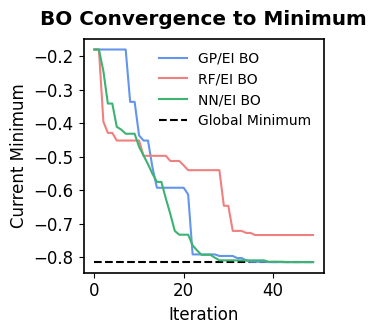

In [26]:
# Visualze results.
fig, ax = plt.subplots(1,1,figsize=(3.5,3.5))
frames = [i for i in range(len(gp_minima))]
ax.plot(frames, gp_minima, label='GP/EI BO', zorder=3, color='cornflowerblue')
ax.plot(frames, rf_minima, label='RF/EI BO', zorder=3, color='lightcoral')
ax.plot(frames, nn_minima, label='NN/EI BO', zorder=3, color='mediumseagreen')
ax.plot(frames, [np.min(labels) for _ in frames], linestyle='dashed', color='black', label='Global Minimum', zorder=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Current Minimum')
ax.legend(fancybox=False, edgecolor='white', prop={'size': 10})
plt.title('BO Convergence to Minimum',pad=10,fontweight='bold')
plt.tight_layout()
plt.show()


Interesting! It looks like model choice plays a large role in BO performance. When using a RF, the BO algorithm isn't able to identify the global minimum over the course of 50 iterations. When using a GP, the BO algorithm settles on the global minimum in about 40 iterations. When using a NN, however, the BO algorithm finds the global minimum in only 30 iterations! While GPs are commonly used in the BO literature, it is worth considering other machine learning models for your BO needs, depending on the task!

#### 2.4 - Review alternative acquisition functions and their impact on BO.

In addition to a ML model, BO requires the specification of an acquisition function. While we have used EI so far, there are other acquisition functions that are commonly used. The two most commonly used outside of EI are probability of improvement (PI) and upper/lower confidence bound (UCB/LCB). Likewise, many acquisition functions come with parameters that modify how "explorative" or "exploitative" your acquisition function is (*i.e.*, it toggles how much you prefer to choose points close or far from things you've already measured). Here, we'll show implementations of EI, PI, and UCB/LCB with different exploration parameters. For a fixed training set, we'll see how these acquisition functions differ. Then, we'll apply them all to the Müller-Brown dataset and see how they cause BO performance to vary.

In [20]:
def expected_improvement(y_pred, y_std, y_min, eta=0.0):
    '''
        Computes the EI acquisition function for all provided labels.
        This implementation is specific to minimization, although a few
        sign changes should make it suitable for maximization.
    '''

    z = (y_min - y_pred - eta) / y_std
    ei = (y_min - y_pred - eta) * norm.cdf(z) + y_std * norm.pdf(z)

    return ei

In [21]:
# Implementation of PI acquisition function.
def probability_of_improvement(y_pred, y_std, y_min, eta=0.0):
    '''
        Computes the PI acquisition function for all provided labels.
        The eta parameter determines the exploration-exploitation tradeoff.
    '''

    # Compute PI.
    z = (y_min - y_pred - eta) / y_std
    pi = norm.cdf(z)

    return pi

In [22]:
# Implementation of UCB/LCB acquisition function.
def lcb(y_pred, y_std, lam=1.0):
    '''
        Computes the LCB acquisition function for all provided labels.
        Since we are minimizing, we compute LCB. A high 'lam', or lambda,
        parameter favors exploration over exploitation.
    '''

    # Compute LCB.
    lcb = -y_pred + lam * y_std

    return lcb

Now that we've seen how these acquisition functions are implemented, we'll visualize them for a fixed set of training data and model for the Müller-Brown dataset. We show the results below.

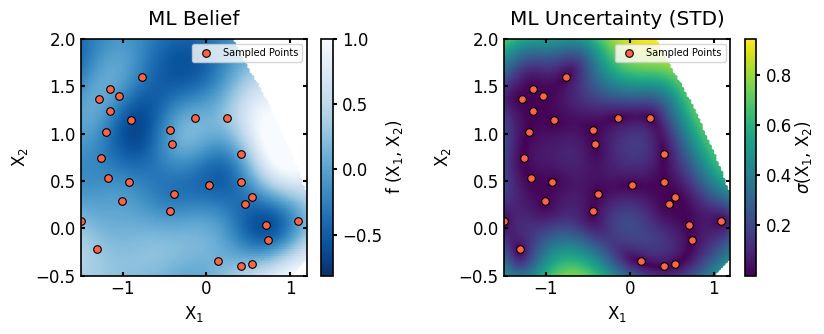

In [23]:
# Choose training data.
np.random.seed(1)
acqs_idx = [i for i in range(domain.shape[0])]
acqs_chosen_idx = np.random.choice(acqs_idx, size=30, replace=False).tolist()

# Get predictions and uncertainties from trained model.
kernel = RBF(length_scale_bounds=(0.1, 10.0))
model = GaussianProcessRegressor(kernel=kernel)
model.fit(domain[acqs_chosen_idx], labels[acqs_chosen_idx])
y_pred, y_std = model.predict(domain, return_std=True)

# Visualize GP model predictions on design space.
fig, axs = plt.subplots(1,2,figsize=(8.4,3.5))
c = axs[0].scatter(domain[:,0], domain[:,1], s=4, c=y_pred, cmap='Blues_r', vmin=vmin, vmax=vmax)
axs[0].scatter(domain[acqs_chosen_idx,0], domain[acqs_chosen_idx,1], s=30, color='tomato', edgecolor='black', linewidth=0.8,label='Sampled Points')
axs[0].set_xlabel(r'X$_1$')
axs[0].set_ylabel(r'X$_2$')
axs[0].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
axs[0].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
axs[0].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
axs[0].set_title('ML Belief',pad=10)
axs[0].legend(loc='upper right', frameon=True, fontsize=7)
cbar = plt.colorbar(c)
cbar.set_label(r'f (X$_1$, X$_2$)', labelpad=1)
cbar.ax.tick_params(width=1.5, length=3.0)

# Visualize GP uncertainties on design space.
c = axs[1].scatter(domain[:,0], domain[:,1], s=4, c=y_std, cmap='viridis')
axs[1].scatter(domain[acqs_chosen_idx,0], domain[acqs_chosen_idx,1], s=30, color='tomato', edgecolor='black', linewidth=0.8,label='Sampled Points')
axs[1].set_xlabel(r'X$_1$')
axs[1].set_ylabel(r'X$_2$')
axs[1].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
axs[1].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
axs[1].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
axs[1].set_title('ML Uncertainty (STD)',pad=10)
axs[1].legend(loc='upper right', frameon=True, fontsize=7)
cbar = plt.colorbar(c)
cbar.set_label(r'$\sigma$(X$_1$, X$_2$)', labelpad=1)
cbar.ax.tick_params(width=1.5, length=3.0)

plt.tight_layout()
plt.show()

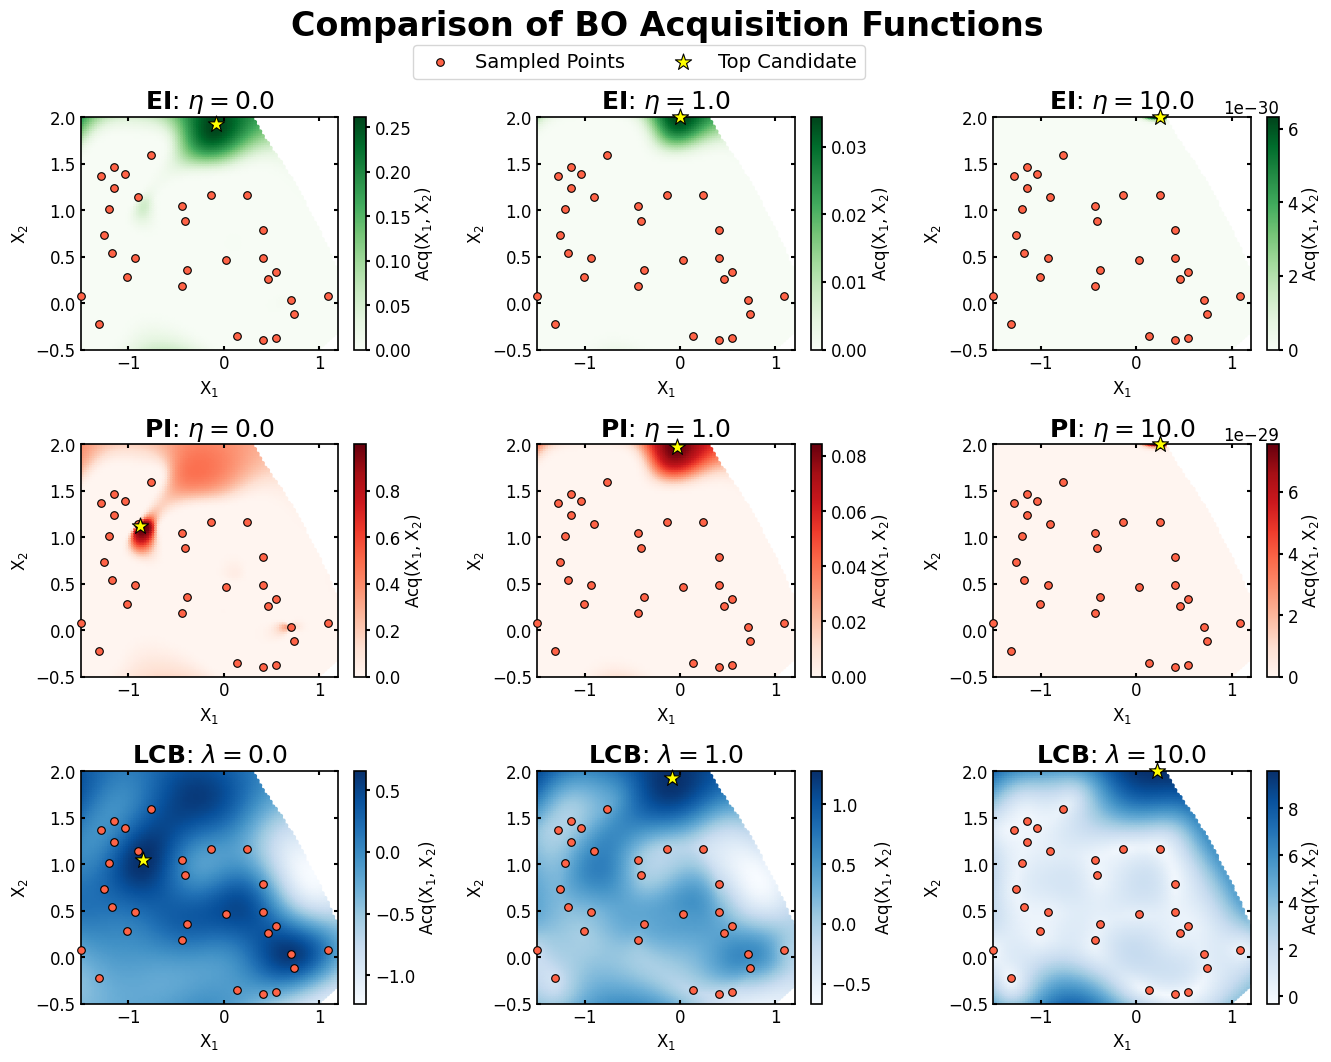

In [24]:
# Show acquisition functions for the results above.
fig, axs = plt.subplots(3,3,figsize=(4.5 * 3, 3.5 * 3))
axs = axs.reshape(-1)
acqs = [
    expected_improvement(y_pred, y_std, np.min(labels[acqs_chosen_idx]), eta=0.0),
    expected_improvement(y_pred, y_std, np.min(labels[acqs_chosen_idx]), eta=1.0),
    expected_improvement(y_pred, y_std, np.min(labels[acqs_chosen_idx]), eta=10.0),
    probability_of_improvement(y_pred, y_std, np.min(labels[acqs_chosen_idx]), eta=0.0),
    probability_of_improvement(y_pred, y_std, np.min(labels[acqs_chosen_idx]), eta=1.0),
    probability_of_improvement(y_pred, y_std, np.min(labels[acqs_chosen_idx]), eta=10.0),
    lcb(y_pred, y_std, lam=0.0),
    lcb(y_pred, y_std, lam=1.0),
    lcb(y_pred, y_std, lam=10.0)
]
titles = [
    r'$\mathbf{EI}$: $\eta = 0.0$',
    r'$\mathbf{EI}$: $\eta = 1.0$',
    r'$\mathbf{EI}$: $\eta = 10.0$',
    r'$\mathbf{PI}$: $\eta = 0.0$',
    r'$\mathbf{PI}$: $\eta = 1.0$',
    r'$\mathbf{PI}$: $\eta = 10.0$',
    r'$\mathbf{LCB}$: $\lambda = 0.0$',
    r'$\mathbf{LCB}$: $\lambda = 1.0$',
    r'$\mathbf{LCB}$: $\lambda = 10.0$',
]
cmaps = [
    'Greens',
    'Greens',
    'Greens',
    'Reds',
    'Reds',
    'Reds',
    'Blues',
    'Blues',
    'Blues',
]
acqs_chosen_idx.append(0)
for idx, acq in enumerate(acqs):
    acqs_chosen_idx[-1] = np.argmax(acq).item()
    c = axs[idx].scatter(domain[:,0], domain[:,1], s=4, c=acq, cmap=cmaps[idx])
    axs[idx].scatter(domain[acqs_chosen_idx,0], domain[acqs_chosen_idx,1], s=30, color='tomato', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10,label='Sampled Points')
    axs[idx].scatter(domain[acqs_chosen_idx[-1],0], domain[acqs_chosen_idx[-1],1], s=150, marker='*', color='yellow', edgecolor='black', linewidth=0.8, clip_on=False, zorder=11,label='Top Candidate')
    axs[idx].set_xlabel(r'X$_1$')
    axs[idx].set_ylabel(r'X$_2$')
    axs[idx].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
    axs[idx].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
    axs[idx].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
    axs[idx].set_title(titles[idx],fontsize=18)
    cbar = plt.colorbar(c)
    cbar.set_label(r'Acq(X$_1$, X$_2$)', labelpad=1)
    cbar.ax.tick_params(width=1.5, length=3.0)

handle, label = axs[1].get_legend_handles_labels()
fig.legend(handle,label,loc=(0.31,0.925),ncol=2,frameon=True,fontsize=14)
fig.suptitle('Comparison of BO Acquisition Functions', fontsize=24, y=1.01,fontweight='bold')
plt.tight_layout()
plt.show()

Above, we show the results of computing different acquisition functions for different values of exploration parameters for each function. We also plot the point in the domain which maximizes the acquistion function to show how these functions cause variation in the choice of new experiments. EI and PI seem to highlight similar areas of the domain, and we see that increasing the exploration parameter pushes the selection further and further from currently chosen points. LCB, on the other hand, higlights a completely different area of the design space for low exploration parameters. This makes sense; the acquisition function is essentially choosing the point in the space with the smallest predicted value. With increasing values of the exploration parameter, however, the selected point is pushed towards the same region chosen by EI and PI where it has high uncertainty.

Going further, we want to see how the choice of acquisition function impacts BO performance on this dataset. For this investigation, we'll set $\eta$ = 0.0 for EI and PI but leave $\lambda$ = 1.0. We'll use GPRs as our surrogate and run the optimization for 50 iterations. The results are shown below.

In [25]:
# Get performance for GP/EI-BO.
ei_minima = []
print('Performing BO with EI...')
np.random.seed(1)
idx = [i for i in range(domain.shape[0])]
chosen_idx = np.random.choice(idx, size=5, replace=False).tolist()
for iteration in range(50):

    # Fit the GP model to new training data.
    kernel = RBF(length_scale_bounds=(0.1,10.0))
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(domain[chosen_idx], labels[chosen_idx])
    y_pred, y_std = model.predict(domain, return_std=True)

    # Evaluate the acquisition function.
    acq = expected_improvement(y_pred, y_std, np.min(labels[chosen_idx]))

    # Choose a new point and record progress.
    new_idx = np.argmax(acq).item()
    chosen_idx.append(new_idx)
    ei_minima.append(np.min(labels[chosen_idx]))

# Get performance for GP/PI-BO.
pi_minima = []
print('Performing BO with PI...')
np.random.seed(1)
idx = [i for i in range(domain.shape[0])]
chosen_idx = np.random.choice(idx, size=5, replace=False).tolist()
for iteration in range(50):

    # Fit the GP model to new training data.
    kernel = RBF(length_scale_bounds=(0.1,10.0))
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(domain[chosen_idx], labels[chosen_idx])
    y_pred, y_std = model.predict(domain, return_std=True)

    # Evaluate the acquisition function.
    acq = probability_of_improvement(y_pred, y_std, np.min(labels[chosen_idx]))

    # Choose a new point and record progress.
    new_idx = np.argmax(acq).item()
    chosen_idx.append(new_idx)
    pi_minima.append(np.min(labels[chosen_idx]))

# Get performance for GP/LCB-BO.
lcb_minima = []
print('Performing BO with LCB...')
np.random.seed(1)
idx = [i for i in range(domain.shape[0])]
chosen_idx = np.random.choice(idx, size=5, replace=False).tolist()
for iteration in range(50):

    # Fit the GP model to new training data.
    kernel = RBF(length_scale_bounds=(0.1,10.0))
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(domain[chosen_idx], labels[chosen_idx])
    y_pred, y_std = model.predict(domain, return_std=True)

    # Evaluate the acquisition function.
    acq = lcb(y_pred, y_std)

    # Choose a new point and record progress.
    new_idx = np.argmax(acq).item()
    chosen_idx.append(new_idx)
    lcb_minima.append(np.min(labels[chosen_idx]))

print('BO runs completed.')

Performing BO with EI...
Performing BO with PI...
Performing BO with LCB...
BO runs completed.


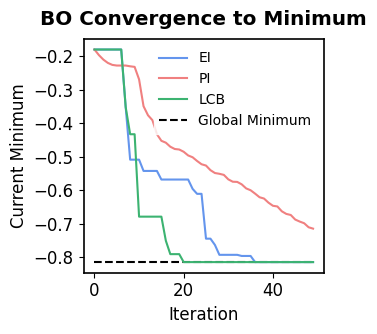

In [27]:
# Visualze results.
fig, ax = plt.subplots(1,1,figsize=(3.5,3.5))
frames = [i for i in range(len(ei_minima))]
ax.plot(frames, ei_minima, label='EI', zorder=3, color='cornflowerblue')
ax.plot(frames, pi_minima, label='PI', zorder=3, color='lightcoral')
ax.plot(frames, lcb_minima, label='LCB', zorder=3, color='mediumseagreen')
ax.plot(frames, [np.min(labels) for _ in frames], linestyle='dashed', color='black', label='Global Minimum', zorder=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Current Minimum')
ax.legend(fancybox=False, edgecolor='white', prop={'size': 10})
plt.title('BO Convergence to Minimum',pad=10,fontweight='bold')
plt.tight_layout()
plt.show()

Interesting again! It looks like acquisition function choice has significant influence on BO performance for this task. The EI and PI acquisition functions perform somewhat differently, which is surprising given their similar formulation and identical exploration parameters. The simpler PI acquisition function was unable to converge to the minimum within the 50 iterations. The LCB acquisition function, however, is able to identify the global minimum nearly twice as fast compared to EI.

#### 2.5 - Introduce batch selection.

The last concept that we will investigate is batch selection. Often, self-driving labs rely on automated experimental equipment capable of running many experiments in parallel. If we only used BO algorithms that choose one point at a time, then we will be wasting our capacity for the SDL to measure many things at once. To take advantage of this, we can use **batch selection**. Batch selection is the process where many measurements are recommended at once, rather than one at a time as we've seen previously. There are many different approaches to batch selection, so we'll just cover one method here.

There are many names for this batch selection method, but we'll refer to it as the **kriging believer** scheme. On a given round of BO, we train our model and compute our acquisition function as usual. However, we want to choose a batch of points instead of choosing a single point to measure. To do this, we'll start by selecting the point which maximizes our acquisition function. Then, we'll assume that our prediction at that point is true. We'll add this point and its fake/hallucinated/dreamed label to our training set, and then we'll retrain our model. We'll regenerate our acquisition function and then choose the point which maximizes this updated acquisition function. We can repeat this process until we reach our desired batch size.

Intuitively, we are choosing batches by asking our model, "Let's assume we were right about the point we just chose. What point would you measure next?" We feel that this is an intuitive way to go about batch selection that circumvents some rather complicated approaches that exist in the literature that attempt to do similar things (*i.e.*, local penalization). Below, we'll implement the kriging believer batch selection scheme, show an example of batch selection, and evaluate the influence of batch size on BO performance.

In [28]:
def choose_batch(model, domain, labels, chosen_idx, y_pred, y_std, batch_size):
    '''
        Implementation of the kriging believer batch selection scheme. Here, we
        use the expected improvement acquisition scheme.
    '''

    # Training data.
    X_train = domain[chosen_idx]
    y_train = labels[chosen_idx]

    for i in range(batch_size):

        # Compute acquisition function based on provided input.
        acq = expected_improvement(y_pred, y_std, y_min=np.min(labels[chosen_idx]))

        # Add point which maximizes acquisition function.
        new_idx = np.argmax(acq).item()
        chosen_idx.append(new_idx)
        X_train = np.vstack((X_train, domain[new_idx].reshape(1,-1)))
        y_train = np.hstack((y_train, y_pred[new_idx].reshape(-1)))

        # Fit model to new training data.
        model.fit(X_train, y_train)
        y_pred, y_std = model.predict(domain, return_std=True)

    return chosen_idx

Now that we see what the code looks like, let's see what batches of different sizes look like for a set amount of training data.

In [55]:
# Choose a new seed dataset.
np.random.seed(1)
idx = [i for i in range(domain.shape[0])]
chosen_idx = np.random.choice(idx, size=15, replace=False).tolist()

# Fit the GP model to new training data.
#model = RandomForestSurrogate()
kernel = RBF(length_scale_bounds=(0.1,10.0))
model = GaussianProcessRegressor(kernel=kernel)
model.fit(domain[chosen_idx], labels[chosen_idx])
y_pred, y_std = model.predict(domain, return_std=True)

# Choose batches of different sizes.
b1_idx = choose_batch(model, domain, labels, chosen_idx.copy(), y_pred, y_std, batch_size=1)
b5_idx = choose_batch(model, domain, labels, chosen_idx.copy(), y_pred, y_std, batch_size=5)
b10_idx = choose_batch(model, domain, labels, chosen_idx.copy(), y_pred, y_std, batch_size=10)

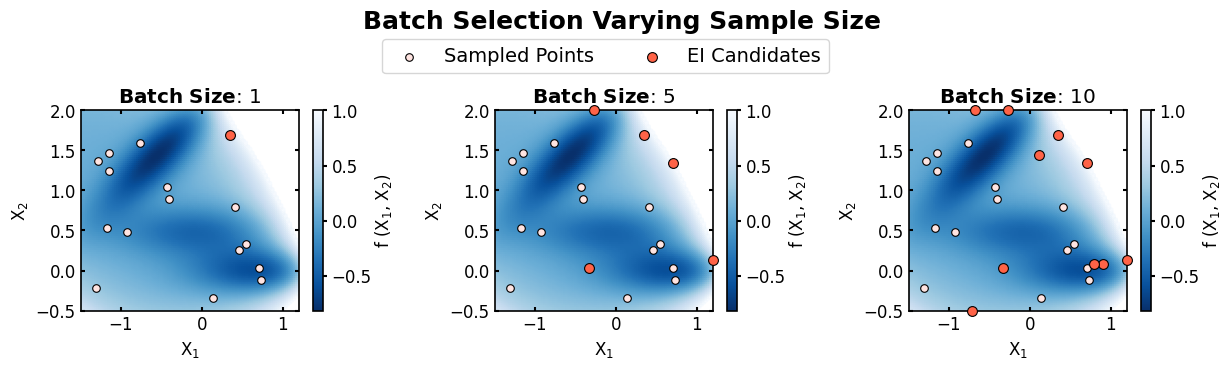

In [77]:
# Visualize batches of different sizes.
fig, axs = plt.subplots(1,3,figsize=(4.2 * 3, 3.5 * 1))
c = axs[0].scatter(domain[:,0], domain[:,1], s=4, c=labels, cmap=plt.get_cmap('Blues_r'))
axs[0].scatter(domain[chosen_idx,0], domain[chosen_idx,1], s=30, color='mistyrose', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10,label='Sampled Points')
axs[0].scatter(domain[b1_idx[-1],0], domain[b1_idx[-1],1], s=50, color='tomato', edgecolor='black', linewidth=0.8, clip_on=False, zorder=11,label='EI Candidates')
axs[0].set_xlabel(r'X$_1$')
axs[0].set_ylabel(r'X$_2$')
axs[0].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
axs[0].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
axs[0].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
axs[0].set_title(r'$\mathbf{Batch}$ $\mathbf{Size}$: 1')
cbar = plt.colorbar(c)
cbar.set_label(r'f (X$_1$, X$_2$)', labelpad=1)
cbar.ax.tick_params(width=1.5, length=3.0)

c = axs[1].scatter(domain[:,0], domain[:,1], s=4, c=labels, cmap=plt.get_cmap('Blues_r'))
axs[1].scatter(domain[chosen_idx,0], domain[chosen_idx,1], s=30, color='mistyrose', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10,label='Sampled Points')
axs[1].scatter(domain[b5_idx[-5:],0], domain[b5_idx[-5:],1], s=50, color='tomato', edgecolor='black', linewidth=0.8, clip_on=False, zorder=11,label='EI Candidates')
axs[1].set_xlabel(r'X$_1$')
axs[1].set_ylabel(r'X$_2$')
axs[1].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
axs[1].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
axs[1].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
axs[1].set_title(r'$\mathbf{Batch}$ $\mathbf{Size}$: 5')
cbar = plt.colorbar(c)
cbar.set_label(r'f (X$_1$, X$_2$)', labelpad=1)
cbar.ax.tick_params(width=1.5, length=3.0)

c = axs[2].scatter(domain[:,0], domain[:,1], s=4, c=labels, cmap=plt.get_cmap('Blues_r'))
axs[2].scatter(domain[chosen_idx,0], domain[chosen_idx,1], s=30, color='mistyrose', edgecolor='black', linewidth=0.8, clip_on=False, zorder=10,label='Sampled Points')
axs[2].scatter(domain[b10_idx[-10:],0], domain[b10_idx[-10:],1], s=50, color='tomato', edgecolor='black', linewidth=0.8, clip_on=False, zorder=11,label='EI Candidates')
axs[2].set_xlabel(r'X$_1$')
axs[2].set_ylabel(r'X$_2$')
axs[2].set_xlim(xmin=np.min(domain[:,0]), xmax=np.max(domain[:,0]))
axs[2].set_ylim(ymin=np.min(domain[:,1]), ymax=np.max(domain[:,1]))
axs[2].tick_params(axis='both', left=True, right=True, top=True, bottom=True, direction='in', width=1.5, length=3)
axs[2].set_title(r'$\mathbf{Batch}$ $\mathbf{Size}$: 10')
cbar = plt.colorbar(c)
cbar.set_label(r'f (X$_1$, X$_2$)', labelpad=1)
cbar.ax.tick_params(width=1.5, length=3.0)
handle, label = axs[0].get_legend_handles_labels()
fig.legend(handle,label,loc=(0.31,0.8),ncol=2,frameon=True,fontsize=14)
fig.suptitle('Batch Selection Varying Sample Size', fontsize=18, y=1.05,fontweight='bold')

plt.tight_layout()
plt.show()

We can see that this batch selection strategy results in diverse sets of measurements given how spread out the points are within the domain. To evaluate the impact of batch size on BO outcomes, we run BO for three different batch sizes and monitor BO performance as measurements are made. We show the results below.

In [47]:
# Get performance for GP/EI-BO with batch size of 1.
batch_1_performance = []
print('Performing BO with batch size of 1...')
np.random.seed(1)
idx = [i for i in range(domain.shape[0])]
chosen_idx = np.random.choice(idx, size=15, replace=False).tolist()
batch_1_performance.append([5, np.min(labels[chosen_idx])])
for iteration in range(50):

    # Fit the GP model to new training data.
    kernel = RBF(length_scale_bounds=(0.1,10.0))
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(domain[chosen_idx], labels[chosen_idx])
    y_pred, y_std = model.predict(domain, return_std=True)

    # Get new points.
    chosen_idx = choose_batch(model, domain, labels, chosen_idx, y_pred, y_std, batch_size=1)

    # Record number of points and current minimum.
    batch_1_performance.append([len(chosen_idx), np.min(labels[chosen_idx])])

# Get performance for GP/EI-BO with batch size of 5.
batch_5_performance = []
print('Performing BO with batch size of 5...')
np.random.seed(1)
idx = [i for i in range(domain.shape[0])]
chosen_idx = np.random.choice(idx, size=15, replace=False).tolist()
batch_5_performance.append([5, np.min(labels[chosen_idx])])
for iteration in range(10):

    # Fit the GP model to new training data.
    kernel = RBF(length_scale_bounds=(0.1,10.0))
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(domain[chosen_idx], labels[chosen_idx])
    y_pred, y_std = model.predict(domain, return_std=True)

    # Get new points.
    chosen_idx = choose_batch(model, domain, labels, chosen_idx, y_pred, y_std, batch_size=5)

    # Record number of points and current minimum.
    batch_5_performance.append([len(chosen_idx), np.min(labels[chosen_idx])])

# Get performance for GP/EI-BO with batch size of 10.
batch_10_performance = []
print('Performing BO with batch size of 10...')
np.random.seed(1)
idx = [i for i in range(domain.shape[0])]
chosen_idx = np.random.choice(idx, size=15, replace=False).tolist()
batch_10_performance.append([5, np.min(labels[chosen_idx])])
for iteration in range(5):

    # Fit the GP model to new training data.
    kernel = RBF(length_scale_bounds=(0.1,10.0))
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(domain[chosen_idx], labels[chosen_idx])
    y_pred, y_std = model.predict(domain, return_std=True)

    # Get new points.
    chosen_idx = choose_batch(model, domain, labels, chosen_idx, y_pred, y_std, batch_size=10)

    # Record number of points and current minimum.
    batch_10_performance.append([len(chosen_idx), np.min(labels[chosen_idx])])

# Convert all results to numpy arrays.
batch_1_performance = np.array(batch_1_performance)
batch_5_performance = np.array(batch_5_performance)
batch_10_performance = np.array(batch_10_performance)
print('Completed!')

Performing BO with batch size of 1...
Performing BO with batch size of 5...
Performing BO with batch size of 10...
Completed!


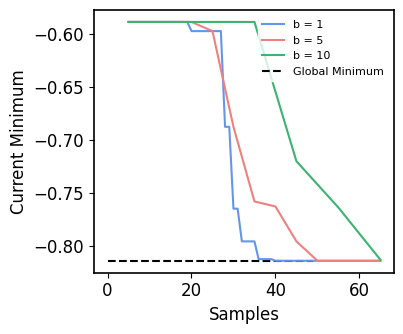

In [49]:
# Visualze results.
fig, ax = plt.subplots(1,1,figsize=(4.2,3.5))
frames = [i for i in range(len(gp_minima))]
ax.plot(batch_1_performance[:,0], batch_1_performance[:,1], label='b = 1', zorder=3, color='cornflowerblue')
ax.plot(batch_5_performance[:,0], batch_5_performance[:,1], label='b = 5', zorder=3, color='lightcoral')
ax.plot(batch_10_performance[:,0], batch_10_performance[:,1], label='b = 10', zorder=3, color='mediumseagreen')
ax.plot(frames, [np.min(labels) for _ in frames], linestyle='dashed', color='black', label='Global Minimum', zorder=2)
ax.set_xlabel('Samples')
ax.set_ylabel('Current Minimum')
ax.legend(fancybox=False, edgecolor='white', prop={'size': 8})
plt.tight_layout()
plt.show()

Surprisingly, we see that the results of BO are mostly independent of batch size. All BO implementations approach the global minimum at approximately the same rate for batches of size 1, 5, and 10. Even though the total number of samples is somewhat higher for batch size 10 as compared to batch size 1, it only had to perform 5 rounds as compared to 50, making it more **time** efficient but less **resource** efficient.

#### Notebook 2 Summary

In this notebook, we extended BO to two-dimensional functions using the Müller-Brown potential as our test case. We explored how model choice can cause variation in BO performance using GPs, RFs, and NNs as ML models. We also explored how acquisition functions, like EI, PI, and LCB can impact BO performance, and that most acquisition functions have parameters that allow you as the user to bias new measurements to be far away from points that have already been measured. Finally, we implemented the **kriging believer** batch selection scheme to take advantage of an SDL's capacity to run experiments in parallel. By now, we hope you feel more comfortable with BO and its various implementations on multi-dimensional tasks. With this knowledge in hand, we encourage you to check out check SDL Notebook (Tutorial Notebook 3) that uses BO to optimize over a high-dimensional materials design space!